In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os, glob
import gc
import sys
sys.path.insert(0, '/home/sonic/Coding/Git/CPMG_Analysis/2nd_automation/')
from decom_utils import *
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from multiprocessing import Pool
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
TIME_DATA = np.load('/home/sonic/Coding/Git/CPMG_Analysis/data/20190610_time_no_duplicated.npy')*1e-6 
EXP_DATA = np.load('/home/sonic/Coding/Git/CPMG_Analysis/data/20190610_exp_data_24200.npy').squeeze() 
# EXP_DATA = np.load('/home/sonic/Coding/Git/temp/Denoise_exp/clean_exp_data_24000.npy').squeeze() 
time_data = TIME_DATA[:12000] 
exp_data = EXP_DATA[:12000]
denoise_data = np.load('/home/sonic/Coding/Git/temp/Denoise_exp/clean_exp_data_24000.npy')

MAGNETIC_FIELD = 403.7139663551402            # Unit: Gauss
GYRO_MAGNETIC_RATIO = 1.07*1000               # Unit: Herts
WL_VALUE = MAGNETIC_FIELD*GYRO_MAGNETIC_RATIO*2*np.pi
N_PULSE_32 = 32

SLOPE_INDEX = 11812
MEAN_PX_VALUE = 0.96     # exp_data[11755:11870].mean() + 0.018
slope = gaussian_slope(time_data, SLOPE_INDEX, MEAN_PX_VALUE, None) 

spin_bath = np.load("/home/sonic/Coding/Git/CPMG_Analysis/data/spin_bath_M_value.npy")

In [25]:
# filtered_idx 만드는 조건
MARGIN = 0              # peak에서 얼마나 넓게 볼것인지
WIDTH_THRESHOLD = 70    # peak 사이의 간격을 얼마나 잡을지.(이건 크게 영향을 미치지 않음)

# 모델을 만들 AB 범위
A_start = -60000
A_end = 60000
B_start = 2000
B_end = 70000
A_interval = 1000
B_interval = 2000

# 뽑을 spin 개수 및 target 스핀 한 개당 만들 data의 개수
n_of_spins = 28
n_of_small_spins = 13
n_of_samples_per_target = 40000

# AB 후보 범위
A_candidate_max = 70000
A_candidate_min = -70000
B_candidate_max = 70000
B_candidate_min = 2000

# small AB 후보 범위
A_small_max = 25000
A_small_min = -25000
B_small_max = 14000
B_small_min = 2000

In [26]:
# Model Hyperparameter
SAVE_MODEL_DIR = '/data2/torch_model_5th/'
POOL_PROCESS = 15
CUDA_DEVICE = 0

batch_size = 4096
learning_rate = 1e-3
epochs = 150

# Sample Number
N_SAMPLES_PER_TARGET = batch_size * 9
N_VALID_SAMPLES = 2048
data_batch = N_SAMPLES_PER_TARGET + N_VALID_SAMPLES
valid_data_batch = N_VALID_SAMPLES

A_pair1 = np.arange(A_start, A_end, A_interval)  
A_pair2 = np.arange(A_start, A_end, A_interval) + A_interval
A_range_list = [[a,b] for a,b in zip(A_pair1, A_pair2)]

B_pair1 = np.arange(B_start, B_end, B_interval)  
B_pair2 = np.arange(B_start, B_end, B_interval) + B_interval
B_range_list = [[a,b] for a,b in zip(B_pair1, B_pair2)]  

idx = np.array([[67, 27], [70, 27], [73, 27], [67, 24], [70, 24], [73, 24], [67, 30], [70, 30], [73, 30],  
                [57, 3], [60, 3], [63, 3], [57, 6], [60, 6], [63, 6], [57, 9], [60, 9], [63, 9], 
                [59, 3], [62, 3], [65, 3], [59, 6], [62, 6], [65, 6], [59, 9], [62, 9], [65, 9]]) 
model_step = 3
AB_total_dic = {}

for count, [i, j] in enumerate(idx):
    A_test = A_range_list[i:i+model_step]
    B_test = B_range_list[j:j+model_step] 
    
    AB_dic = {}
    for idx1, A_range in enumerate(A_test):
        for idx2, B_range in enumerate(B_test):
            AB_dic[idx1*len(B_test)+idx2] = [[idx1, idx2], [A_range, B_range]] 
    AB_total_dic[count] = AB_dic

In [28]:
# AB 후보 범위
A_candidate_max = 70000
A_candidate_min = -70000
B_candidate_max = 70000
B_candidate_min = 2000

# small AB 후보 범위
A_small_max = 25000
A_small_min = -25000
B_small_max = 14000
B_small_min = 2000

# Model Hyperparameter
SAVE_MODEL_DIR = '/data2/torch_model_5th/'
POOL_PROCESS = 15
CUDA_DEVICE = 0
pool = Pool(processes=POOL_PROCESS)
torch.cuda.set_device(device=CUDA_DEVICE)

batch_size = 4096
learning_rate = 1e-3
epochs = 150

N_SAMPLES_PER_TARGET = 40960
N_VALID_SAMPLES = 2048
train_data_batch = N_SAMPLES_PER_TARGET
valid_data_batch = N_VALID_SAMPLES

tic = time.time()
for idx_model, AB_dic in AB_total_dic.items():        

    PRE_PROCESSING = False
    AB_lists = np.zeros((10, train_data_batch+valid_data_batch, n_of_spins, 2))
    total_filtered_idx = []

    for idx, AB_range in AB_dic.items():
        A_range = AB_range[1][0][0]
        B_range = AB_range[1][1][0]
        A = (A_range+A_interval/4) + A_interval/2 * np.random.uniform(0, 1, train_data_batch+valid_data_batch) 
        B = (B_range+B_interval/4) + B_interval/2 * np.random.uniform(0, 1, train_data_batch+valid_data_batch) 

        M_temp = M_list_return(time_data, WL_VALUE, [[(A_range+A_interval/2)*2*np.pi, (B_range+B_interval/2)*2*np.pi]], N_PULSE_32)
        fil_idx = get_filtered_idx(M_temp, margin=MARGIN, width_threshold=WIDTH_THRESHOLD)
        total_filtered_idx += list(fil_idx)

        AB_lists[idx, :, 0, :] = np.array([[A,B] for A,B in zip(A,B)])

        A_candidate = np.random.uniform(A_candidate_min, A_candidate_max, size=(train_data_batch+valid_data_batch, n_of_spins-n_of_small_spins-1))
        AB_lists[idx, :, 1:n_of_spins-n_of_small_spins, 0] = A_candidate
        A_small_candidate = np.random.uniform(A_small_min, A_small_max, size=(train_data_batch+valid_data_batch, n_of_small_spins))
        AB_lists[idx, :, n_of_spins-n_of_small_spins:, 0] = A_small_candidate

        B_candidate = np.random.uniform(B_candidate_min, B_candidate_max, size=(train_data_batch+valid_data_batch, n_of_spins-n_of_small_spins-1))
        AB_lists[idx, :, 1:n_of_spins-n_of_small_spins, 1] = B_candidate
        B_small_candidate = np.random.uniform(B_small_min, B_small_max, size=(train_data_batch+valid_data_batch, n_of_small_spins))
        AB_lists[idx, :, n_of_spins-n_of_small_spins:, 1] = B_small_candidate

        # 조건에 맞지않는 것 바꾸기
        bool_condition = (AB_lists[idx, :, 1:, 0] >= A_range) & (AB_lists[idx, :, 1:, 0] <= A_range+A_interval) \
                       & (AB_lists[idx, :, 1:, 1] >= B_range) & (AB_lists[idx, :, 1:, 1] <= B_range+B_interval)
        bool_mask = np.full(AB_lists.shape, False)
        bool_mask[idx, :, 1:, 0] = bool_condition
        bool_mask[idx, :, 1:, 1] = bool_condition

        count = 0
        model_indices = []
        while True in bool_condition:
            indices, _ = np.where(bool_mask[idx, :, 1:n_of_spins-n_of_small_spins, 0]==True)
            AB_lists[idx, :, 1:n_of_spins-n_of_small_spins, 0][bool_mask[idx, :, 1:n_of_spins-n_of_small_spins, 0]] \
                                    = np.random.uniform(A_candidate_min, A_candidate_max, size=indices.shape)
            AB_lists[idx, :, 1:n_of_spins-n_of_small_spins, 1][bool_mask[idx, :, 1:n_of_spins-n_of_small_spins, 0]] \
                                    = np.random.uniform(B_candidate_min, B_candidate_max, size=indices.shape)
            indices, _ = np.where(bool_mask[idx, :, n_of_spins-n_of_small_spins:, 0]==True)
            AB_lists[idx, :, n_of_spins-n_of_small_spins:, 0][bool_mask[idx, :, n_of_spins-n_of_small_spins:, 0]] \
                                    = np.random.uniform(A_small_min, A_small_max, size=indices.shape)
            AB_lists[idx, :, n_of_spins-n_of_small_spins:, 1][bool_mask[idx, :, n_of_spins-n_of_small_spins:, 1]] \
                                    = np.random.uniform(B_small_min, B_small_max, size=indices.shape)
            
            bool_condition = (AB_lists[idx, :, 1:, 0] >= A_range) & (AB_lists[idx, :, 1:, 0] <= A_range+A_interval) \
                           & (AB_lists[idx, :, 1:, 1] >= B_range) & (AB_lists[idx, :, 1:, 1] <= B_range+B_interval)
            bool_mask = np.full(AB_lists.shape, False)
            bool_mask[idx, :, 1:, 0] = bool_condition
            bool_mask[idx, :, 1:, 1] = bool_condition

    # 마지막 index의 A,B를 넣어주는 것(위에서는 target만 넣었으므로)
    AB_lists[-1, :, 0, 0] = np.random.uniform(A_candidate_min, A_candidate_max, train_data_batch+valid_data_batch)
    AB_lists[-1, :, 0, 1] = np.random.uniform(B_candidate_min, B_candidate_max, train_data_batch+valid_data_batch)

    bool_condition = ((AB_lists[-1, :, 0, 0] >= A_range) & (AB_lists[-1, :, 0, 0] <= A_range+A_interval)) & \
                      ((AB_lists[-1, :, 0, 1] >= B_range) & (AB_lists[-1, :, 0, 1] <= B_range+B_interval))
    while True in bool_condition:
        AB_lists[-1, :, 0, 0] = np.where(bool_condition,
                               np.random.uniform(A_candidate_min, A_candidate_max), AB_lists[-1, :, 0, 0]) 
        AB_lists[-1, :, 0, 1] = np.where(bool_condition, 
                               np.random.uniform(B_candidate_min, B_candidate_max), AB_lists[-1, :, 0, 1]) 
        bool_condition = ((AB_lists[-1, :, 0, 0] >= A_range) & (AB_lists[-1, :, 0, 0] <= A_range+A_interval)) & \
                          ((AB_lists[-1, :, 0, 1] >= B_range) & (AB_lists[-1, :, 0, 1] <= B_range+B_interval))

    total_filtered_idx = np.array(list(set(total_filtered_idx)))
    print("total index length:", len(total_filtered_idx)) 
    
    # 2*np.pi 곱해주는 것은, 실수로 두번 곱하거나, 혹은 곱하지 않을 때가 많다. 반드시 확인해줘야 함. 확인하는 법은, X_train을 만들고 그래프의 value가 어떤지 확인할 것
    AB_lists = AB_lists*2*np.pi  
    
    #Generate training data
    for i in range(AB_lists.shape[0]):
        globals()["pool_{}".format(i)] = pool.apply_async(gen_X_train, [AB_lists[i][:train_data_batch], time_data[total_filtered_idx], WL_VALUE, N_PULSE_32])    
        globals()["pool_val_{}".format(i)] = pool.apply_async(gen_X_train, [AB_lists[i][train_data_batch:train_data_batch+valid_data_batch], time_data[total_filtered_idx], WL_VALUE, N_PULSE_32])    

    X_train_arr = np.zeros((AB_lists.shape[0], train_data_batch, total_filtered_idx.shape[0]))
    Y_train_arr = np.zeros((AB_lists.shape[0], X_train_arr.shape[1], AB_lists.shape[0]))
    X_valid_arr = np.zeros((AB_lists.shape[0], valid_data_batch, total_filtered_idx.shape[0]))
    Y_valid_arr = np.zeros((AB_lists.shape[0], X_valid_arr.shape[1], AB_lists.shape[0]))
    
    for j in range(AB_lists.shape[0]):
        X_train_arr[j] = globals()["pool_{}".format(j)].get(timeout=None)
        X_valid_arr[j] = globals()["pool_val_{}".format(j)].get(timeout=None)
        Y_train_arr[j, :, j] = 1
        Y_valid_arr[j, :, j] = 1        

    print("Data Generation completed. Time consumed: {} (s)".format(time.time() - tic))
    break

total index length: 1266
Data Generation completed. Time consumed: 249.77450394630432 (s)


Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Process ForkPoolWorker-37:
Process ForkPoolWorker-39:
Process ForkPoolWorker-34:
Process ForkPoolWorker-31:
Process ForkPoolWorker-32:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-41:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/proc

  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [29]:
X_train_arr = X_train_arr.reshape(-1, len(total_filtered_idx))
Y_train_arr = Y_train_arr.reshape(-1, Y_train_arr.shape[-1])
X_valid_arr = X_valid_arr.reshape(-1, len(total_filtered_idx))
Y_valid_arr = Y_valid_arr.reshape(-1, Y_valid_arr.shape[-1])

In [30]:
X_train_arr, Y_train_arr = shuffle(X_train_arr, Y_train_arr)
X_valid_arr, Y_valid_arr = shuffle(X_valid_arr, Y_valid_arr)

In [31]:
X_train_arr.shape, Y_train_arr.shape, X_valid_arr.shape, Y_valid_arr.shape,

((409600, 1266), (409600, 10), (20480, 1266), (20480, 10))

2329

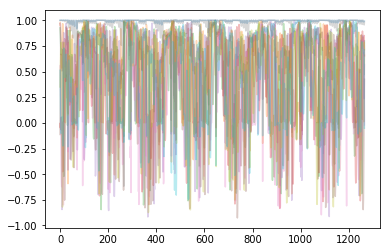

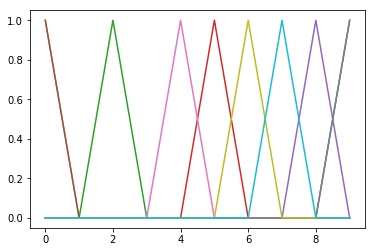

In [32]:
idx2 = np.random.randint(X_train_arr.shape[0] - 10) 
plt.figure(facecolor='w')
for i in range(10):
    plt.plot(X_train_arr[idx2+i], alpha=0.3)
#     print(idx2)
plt.figure(facecolor='w')
for i in range(10):
    plt.plot(Y_train_arr[idx2+i])
#     print(idx2)
idx2

In [33]:
model = torch.nn.Sequential(
            nn.Linear(len(total_filtered_idx), 4096, bias=True),
            nn.ReLU(),
#             nn.Dropout(p=0.1),
            nn.Linear(4096, 2048, bias=True),
            nn.ReLU(),
#             nn.Dropout(p=0.1),
            nn.Linear(2048, 1024, bias=True),
            nn.ReLU(),
#             nn.Dropout(p=0.1),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(),
#             nn.Dropout(p=0.1),
            nn.Linear(512, 10, bias=True),
            nn.Sigmoid()
).cuda()

In [34]:
SAVE_MODEL_DIR = '/data2/torch_model_4th/'
POOL_PROCESS = 15
CUDA_DEVICE = 0

batch_size = 4096
learning_rate = 0.5e-4
epochs = 150

In [35]:
tic =time.time()
# print("Training Start.. (Pre Process:{})".format(PRE_PROCESSING))
model.train()
total_val_loss = []
total_acc = []

In [36]:
summary(model, (1, len(total_filtered_idx)))
criterion = torch.nn.BCELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_batch = len(X_train_arr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]       5,189,632
              ReLU-2              [-1, 1, 4096]               0
            Linear-3              [-1, 1, 2048]       8,390,656
              ReLU-4              [-1, 1, 2048]               0
            Linear-5              [-1, 1, 1024]       2,098,176
              ReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 512]         524,800
              ReLU-8               [-1, 1, 512]               0
            Linear-9                [-1, 1, 10]           5,130
          Sigmoid-10                [-1, 1, 10]               0
Total params: 16,208,394
Trainable params: 16,208,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 61.83
Esti

In [37]:
for epoch in range(epochs):
    avg_cost = 0

    for i in range(total_batch // batch_size):

        indices = torch.randperm(total_batch)[:batch_size]
        x_train_temp = torch.tensor(X_train_arr[indices], dtype=torch.float).cuda()
        y_train_temp = torch.tensor(Y_train_arr[indices], dtype=torch.float).cuda()

        optimizer.zero_grad()
        hypothesis = model(x_train_temp)
        cost = criterion(hypothesis, y_train_temp)
        cost.backward()
        optimizer.step()

        avg_cost += cost

    print('Epoch:', '%4d' % (epoch + 1), ' | Loss =', '{:.5f}'.format(avg_cost / (total_batch // batch_size)), end=' | ')

    with torch.no_grad():
        model.eval()
        X_valid_t = torch.tensor(X_valid_arr, dtype=torch.float).cuda()
        Y_valid_t = torch.tensor(Y_valid_arr, dtype=torch.float).cuda()

        prediction = model(X_valid_t)
        val_loss = criterion(prediction, Y_valid_t)

        bool_pred = torch.argmax(prediction, dim=1, keepdim=True)
        bool_y = torch.argmax(Y_valid_t, dim=1, keepdim=True)
        # accuracy = torch.tensor(torch.sum(bool_pred == bool_y), dtype=torch.float) / len(X_valid_arr) * 100
        accuracy = torch.sum(bool_pred == bool_y).float() / len(X_valid_arr) * 100
        print('Val_loss: {:.5f} | Accuracy: {:.2f} %'.format(val_loss.item(), accuracy.item()))
        total_val_loss.append(val_loss.cpu().detach().item())
        total_acc.append(accuracy.cpu().detach().item())

#     if total_acc[-1] > 92:
#         break
#     try:
#         if ((total_val_loss[-8] + total_val_loss[-7] + total_val_loss[-6] + total_val_loss[-5]) - \
#             max(total_val_loss[-8], total_val_loss[-7], total_val_loss[-6], total_val_loss[-5])) < \
#            ((total_val_loss[-4] + total_val_loss[-3] + total_val_loss[-2] + total_val_loss[-1]) - \
#             max(total_val_loss[-4], total_val_loss[-3], total_val_loss[-2], total_val_loss[-1])):
#             break
#     except:pass

toc =time.time()
print("Training Done. {} (s)".format(toc-tic))

print("Prediction..")

# if PRE_PROCESSING:
#     exp_data = pre_processing(exp_data, power=power)
# else:
#     pass

new_denoise = 2*denoise_data[:12000] - 1 
new_denoise = new_denoise/slope

new_denoise_tensor = torch.FloatTensor(new_denoise[total_filtered_idx].reshape(1, -1)).cuda()
pred = model(new_denoise_tensor)

# folder_idx = int(file_list[idx].split('total_')[-1].split('.npy')[0].split('_')[1])
folder_idx = 'temp'

if os.path.isdir(SAVE_MODEL_DIR + "{}/".format(folder_idx)):pass
else:
    os.mkdir(SAVE_MODEL_DIR + "{}/".format(folder_idx))

np.save(SAVE_MODEL_DIR + "{}/{}_pred_values.npy".format(folder_idx,folder_idx), pred.cpu().detach().numpy())
np.save(SAVE_MODEL_DIR + "{}/{}_val_loss_{}(s).npy".format(folder_idx,folder_idx, np.round(toc-tic)), np.array(total_val_loss))
np.save(SAVE_MODEL_DIR + "{}/{}_val_acc.npy".format(folder_idx,folder_idx), np.array(total_acc))
torch.save(model, SAVE_MODEL_DIR + '{}/{}_torch_model'.format(folder_idx, folder_idx))
# torch.save(model, SAVE_MODEL_DIR + '{}/{}_torch_model_{}'.format(folder_idx, folder_idx, PRE_PROCESSING))
print("Model Saved.")
print("Prediction : ", pred, "\nTotal_val_loss:", total_val_loss[-4:], "\ntotal_acc: ", total_acc[-4:])

# del X_train_arr, X_valid_arr, model, X_valid, Y_valid
torch.cuda.empty_cache()
# print("===================== Training Done. File: {}".format(file_list[idx].split('total_')[-1]))

Epoch:    1  | Loss = 0.29275 | Val_loss: 0.14295 | Accuracy: 65.52 %
Epoch:    2  | Loss = 0.12574 | Val_loss: 0.11799 | Accuracy: 68.24 %
Epoch:    3  | Loss = 0.11324 | Val_loss: 0.10887 | Accuracy: 70.80 %
Epoch:    4  | Loss = 0.10372 | Val_loss: 0.09771 | Accuracy: 76.09 %
Epoch:    5  | Loss = 0.08995 | Val_loss: 0.08202 | Accuracy: 82.87 %
Epoch:    6  | Loss = 0.07427 | Val_loss: 0.06835 | Accuracy: 86.54 %
Epoch:    7  | Loss = 0.06172 | Val_loss: 0.05822 | Accuracy: 88.38 %
Epoch:    8  | Loss = 0.05331 | Val_loss: 0.05077 | Accuracy: 89.75 %
Epoch:    9  | Loss = 0.04694 | Val_loss: 0.04602 | Accuracy: 90.46 %
Epoch:   10  | Loss = 0.04231 | 

KeyboardInterrupt: 

In [39]:
torch.cuda.empty_cache()

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os, glob
import gc
import sys
sys.path.insert(0, '/home/sonic/Coding/Git/CPMG_Analysis/2nd_automation/')
from decom_utils import *
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from multiprocessing import Pool
from sklearn.utils import shuffle

Using TensorFlow backend.


## filtered_idx 길이가 0이라서 다시 해보는 코드

In [4]:

TIME_DATA = np.load('/home/sonic/Coding/Git/CPMG_Analysis/data/20190610_time_no_duplicated.npy')*1e-6 
EXP_DATA = np.load('/home/sonic/Coding/Git/CPMG_Analysis/data/20190610_exp_data_24200.npy').squeeze() 
# EXP_DATA = np.load('/home/sonic/Coding/Git/temp/Denoise_exp/clean_exp_data_24000.npy').squeeze() 
time_data = TIME_DATA[:12000] 
exp_data = EXP_DATA[:12000]
denoise_data = np.load('/home/sonic/Coding/Git/temp/Denoise_exp/clean_exp_data_24000.npy')

MAGNETIC_FIELD = 403.7139663551402            # Unit: Gauss
GYRO_MAGNETIC_RATIO = 1.07*1000               # Unit: Herts
WL_VALUE = MAGNETIC_FIELD*GYRO_MAGNETIC_RATIO*2*np.pi
N_PULSE_32 = 32

SLOPE_INDEX = 11812
MEAN_PX_VALUE = 0.96     # exp_data[11755:11870].mean() + 0.018
slope = gaussian_slope(time_data, SLOPE_INDEX, MEAN_PX_VALUE, None) 

spin_bath = np.load("/home/sonic/Coding/Git/CPMG_Analysis/data/spin_bath_M_value.npy")


In [14]:
AB_total_dic[5]

{}

In [46]:
# 모델을 만들 AB 범위
A_start = -60000
A_end = 60000
B_start = 2000
B_end = 74000
A_interval = 1000
B_interval = 2000

# 뽑을 spin 개수 및 target 스핀 한 개당 만들 data의 개수
n_of_spins = 28
n_of_small_spins = 13
n_of_samples_per_target = 40000

# AB 후보 범위
A_candidate_max = 70000
A_candidate_min = -70000
B_candidate_max = 70000
B_candidate_min = 2000

# small AB 후보 범위
A_small_max = 25000
A_small_min = -25000
B_small_max = 14000
B_small_min = 2000

# Model Hyperparameter
SAVE_MODEL_DIR = '/data2/torch_model_5th/'
POOL_PROCESS = 15
CUDA_DEVICE = 0
pool = Pool(processes=POOL_PROCESS)
torch.cuda.set_device(device=CUDA_DEVICE)

batch_size = 4096
learning_rate = 0.5e-3
epochs = 150

# Sample Number
N_SAMPLES_PER_TARGET = batch_size * 9
N_VALID_SAMPLES = 2048
train_data_batch = N_SAMPLES_PER_TARGET
valid_data_batch = N_VALID_SAMPLES

A_pair1 = np.arange(A_start, A_end, A_interval)  
A_pair2 = np.arange(A_start, A_end, A_interval) + A_interval
A_range_list = [[a,b] for a,b in zip(A_pair1, A_pair2)]

B_pair1 = np.arange(B_start, B_end, B_interval)  
B_pair2 = np.arange(B_start, B_end, B_interval) + B_interval
B_range_list = [[a,b] for a,b in zip(B_pair1, B_pair2)]  

A = np.arange(0, len(A_range_list), 3)
B = np.arange(0, 5, 1)


In [48]:
A = np.arange(0, len(A_range_list), 3)
B = np.arange(0, 5, 1)

AB_indices = []
for A_temp in A:
    for B_temp in B:
        AB_indices.append([A_temp,B_temp])
        
model_step = 3
AB_total_dic = {}

for count, [i, j] in enumerate(AB_indices):
    A_test = A_range_list[i:i+model_step]
    B_test = B_range_list[j:j+model_step] 
    
    AB_dic = {}
    for idx1, A_range in enumerate(A_test):
        for idx2, B_range in enumerate(B_test):
            AB_dic[idx1*len(B_test)+idx2] = [[idx1, idx2], [A_range, B_range]] 
    AB_total_dic[count] = AB_dic
    

In [69]:
AB_total_dic

{0: {0: [[0, 0], [[-60000, -59000], [2000, 4000]]],
  1: [[0, 1], [[-60000, -59000], [4000, 6000]]],
  2: [[0, 2], [[-60000, -59000], [6000, 8000]]],
  3: [[1, 0], [[-59000, -58000], [2000, 4000]]],
  4: [[1, 1], [[-59000, -58000], [4000, 6000]]],
  5: [[1, 2], [[-59000, -58000], [6000, 8000]]],
  6: [[2, 0], [[-58000, -57000], [2000, 4000]]],
  7: [[2, 1], [[-58000, -57000], [4000, 6000]]],
  8: [[2, 2], [[-58000, -57000], [6000, 8000]]]},
 1: {0: [[0, 0], [[-60000, -59000], [4000, 6000]]],
  1: [[0, 1], [[-60000, -59000], [6000, 8000]]],
  2: [[0, 2], [[-60000, -59000], [8000, 10000]]],
  3: [[1, 0], [[-59000, -58000], [4000, 6000]]],
  4: [[1, 1], [[-59000, -58000], [6000, 8000]]],
  5: [[1, 2], [[-59000, -58000], [8000, 10000]]],
  6: [[2, 0], [[-58000, -57000], [4000, 6000]]],
  7: [[2, 1], [[-58000, -57000], [6000, 8000]]],
  8: [[2, 2], [[-58000, -57000], [8000, 10000]]]},
 2: {0: [[0, 0], [[-60000, -59000], [6000, 8000]]],
  1: [[0, 1], [[-60000, -59000], [8000, 10000]]],
  2: 

In [66]:
tic = time.time() # Time Caluation Start..

for idx_model, AB_dic in AB_total_dic.items():        
    
    AB_lists = np.zeros((10, train_data_batch+valid_data_batch, n_of_spins, 2))
    total_filtered_idx = []

    for idx, AB_range in AB_dic.items():
        A_range = AB_range[1][0][0]
        B_range = AB_range[1][1][0]
        A = (A_range+A_interval/10) + A_interval/1.25 * np.random.uniform(0, 1, train_data_batch+valid_data_batch) 
        B = (B_range+B_interval/10) + B_interval/1.25 * np.random.uniform(0, 1, train_data_batch+valid_data_batch) 
        break
    break

(array([3951., 3874., 3775., 3978., 3862., 3913., 3997., 3911., 3807.,
        3844.]),
 array([2200.03509665, 2360.02354606, 2520.01199547, 2680.00044487,
        2839.98889428, 2999.97734369, 3159.96579309, 3319.9542425 ,
        3479.94269191, 3639.93114131, 3799.91959072]),
 <a list of 10 Patch objects>)

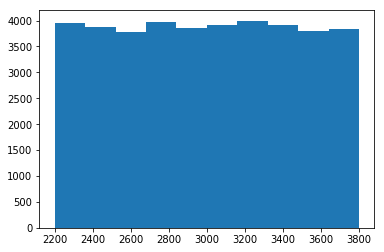

In [68]:
# plt.figure(facecolor='w')
# plt.hist(A)
plt.figure(facecolor='w')
plt.hist(B)